In [1]:
HOST = '37.139.42.145'
DBNAME = 'game-analytics'
USER = 'analytics'
PASSWORD = '*************'
import pandas as pd
from sqlalchemy import create_engine
engine = create_engine(f'postgresql://{USER}:{PASSWORD}@{HOST}/{DBNAME}')
TABLE_SCHEMA ='data_viz_1068.project_dataset'

In [2]:
df=pd.read_sql(f'''
with data as
        (SELECT  event_time,
                 user_id, 
                 event_name, 
                 min(event_time) filter (where event_name='FirstLaunchApp') OVER(PARTITION BY user_id) as date_install
        FROM data_viz_1068.project_dataset
        WHERE user_id in
                    (SELECT user_id
                    FROM data_viz_1068.project_dataset
                    WHERE event_name='FirstLaunchApp'))
SELECT user_id, 
       date_trunc('month', date_install) as install_month,
       case WHEN user_id in
                       (SELECT user_id
                        FROM data_viz_1068.project_dataset
                        WHERE event_name ='af_purchase')
                 then 'payer'
                 else 'not_payer' end as paying_type,
       trim ('achive_level_' from event_name)::int as level,
       extract(epoch from event_time - date_install)/3600:: float as hours
FROM data
WHERE event_name like '%%level%%' and extract(epoch from event_time - date_install):: float>0
        
       
''', con=engine)

In [3]:
df=df.groupby(['install_month','level','paying_type']).agg(max_hours=('hours','max'), min_hours=('hours', 'min'), median_hours=('hours','median'))

In [4]:
df=df.pivot_table(index = ['install_month','paying_type'], columns = 'level', values = ['max_hours','min_hours','median_hours']).reset_index()

In [5]:
df.to_csv('./desktop/Урок_8_Анализ_игровых_метрик.csv')

https://docs.google.com/spreadsheets/d/1_UjATQgFMVcfAOrZ-aT5TWyKNQNIrELaq0X2vMqwJJc/edit?usp=sharing
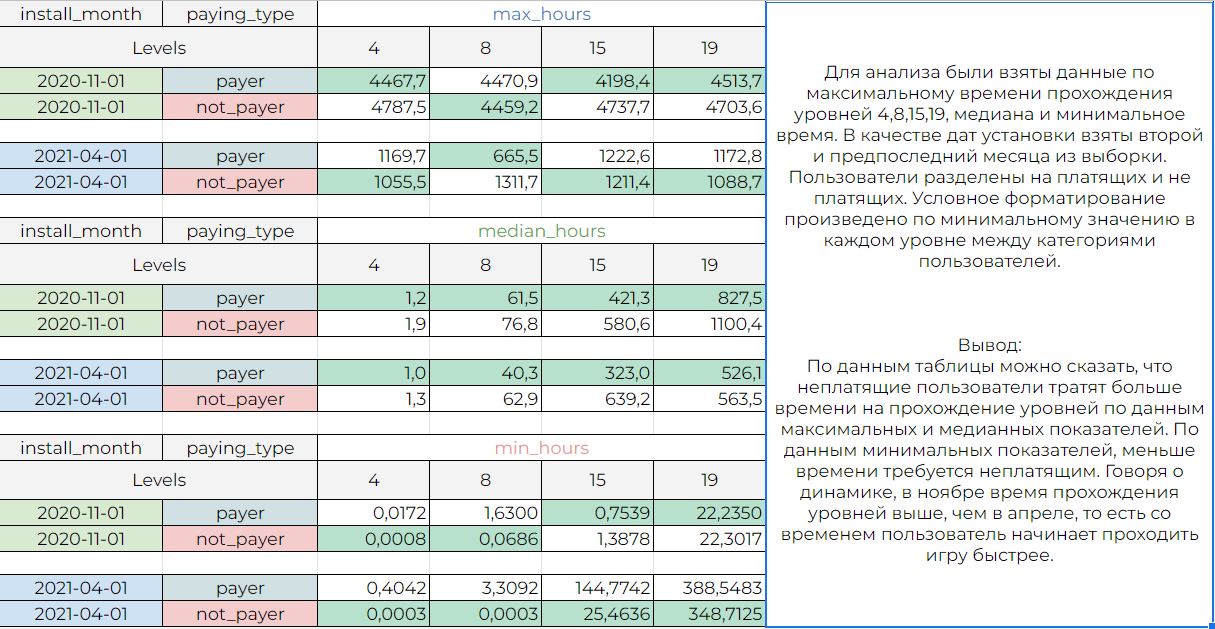